In [4]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import Model

In [5]:
model = keras.applications.VGG16(weights='imagenet', include_top=True)
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)

In [6]:
import glob
import random

images = glob.glob('./img_dataset/**/*.jpg')
random.shuffle(images)
images = images[:600]
len(images)

510

In [7]:
import numpy as np
features = []
for i, image_path in enumerate(images):
    if i % 50 == 0:
        print("analyzed" + str(i) + " out of " + str(len(images)))
    
    img = image.load_img(image_path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feat = feat_extractor.predict(x)[0]
    features.append(feat)   

analyzed0 out of 510
analyzed50 out of 510
analyzed100 out of 510
analyzed150 out of 510
analyzed200 out of 510
analyzed250 out of 510
analyzed300 out of 510
analyzed350 out of 510
analyzed400 out of 510
analyzed450 out of 510
analyzed500 out of 510


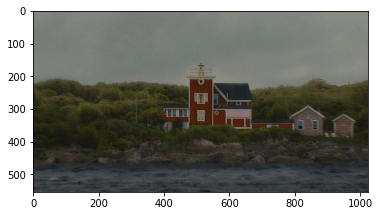

In [8]:
from matplotlib.pyplot import imshow
from PIL import Image
%matplotlib inline
pil_im = Image.open('img_dataset/photo-gallery-2019-10-18-16-50-30/03 (703).jpg', 'r')
imshow(np.asarray(pil_im))

In [9]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
scaled = ss.fit_transform(features)

from sklearn.cluster import MiniBatchKMeans

sum_squared = []
K = range(1, 50)

for i in K:
    print('Calculating ' + str(i))
    kmeans = MiniBatchKMeans(n_clusters=i)
    kmeans.fit(scaled)
    sum_squared.append(kmeans.inertia_)

Calculating 1
Calculating 2
Calculating 3
Calculating 4
Calculating 5
Calculating 6
Calculating 7
Calculating 8
Calculating 9
Calculating 10
Calculating 11
Calculating 12
Calculating 13
Calculating 14
Calculating 15
Calculating 16
Calculating 17
Calculating 18
Calculating 19
Calculating 20
Calculating 21
Calculating 22
Calculating 23
Calculating 24
Calculating 25
Calculating 26
Calculating 27
Calculating 28
Calculating 29
Calculating 30
Calculating 31
Calculating 32
Calculating 33
Calculating 34
Calculating 35
Calculating 36
Calculating 37
Calculating 38
Calculating 39
Calculating 40
Calculating 41
Calculating 42
Calculating 43
Calculating 44
Calculating 45
Calculating 46
Calculating 47
Calculating 48
Calculating 49


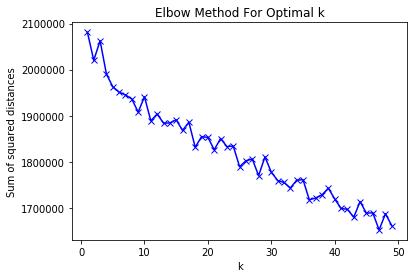

In [10]:
import matplotlib.pyplot as plt

plt.plot(K, sum_squared, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [11]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10)
clusters = kmeans.fit_predict(scaled)

from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=8, metric='cosine').fit(scaled)
_, closest = neighbors.kneighbors(kmeans.cluster_centers_)

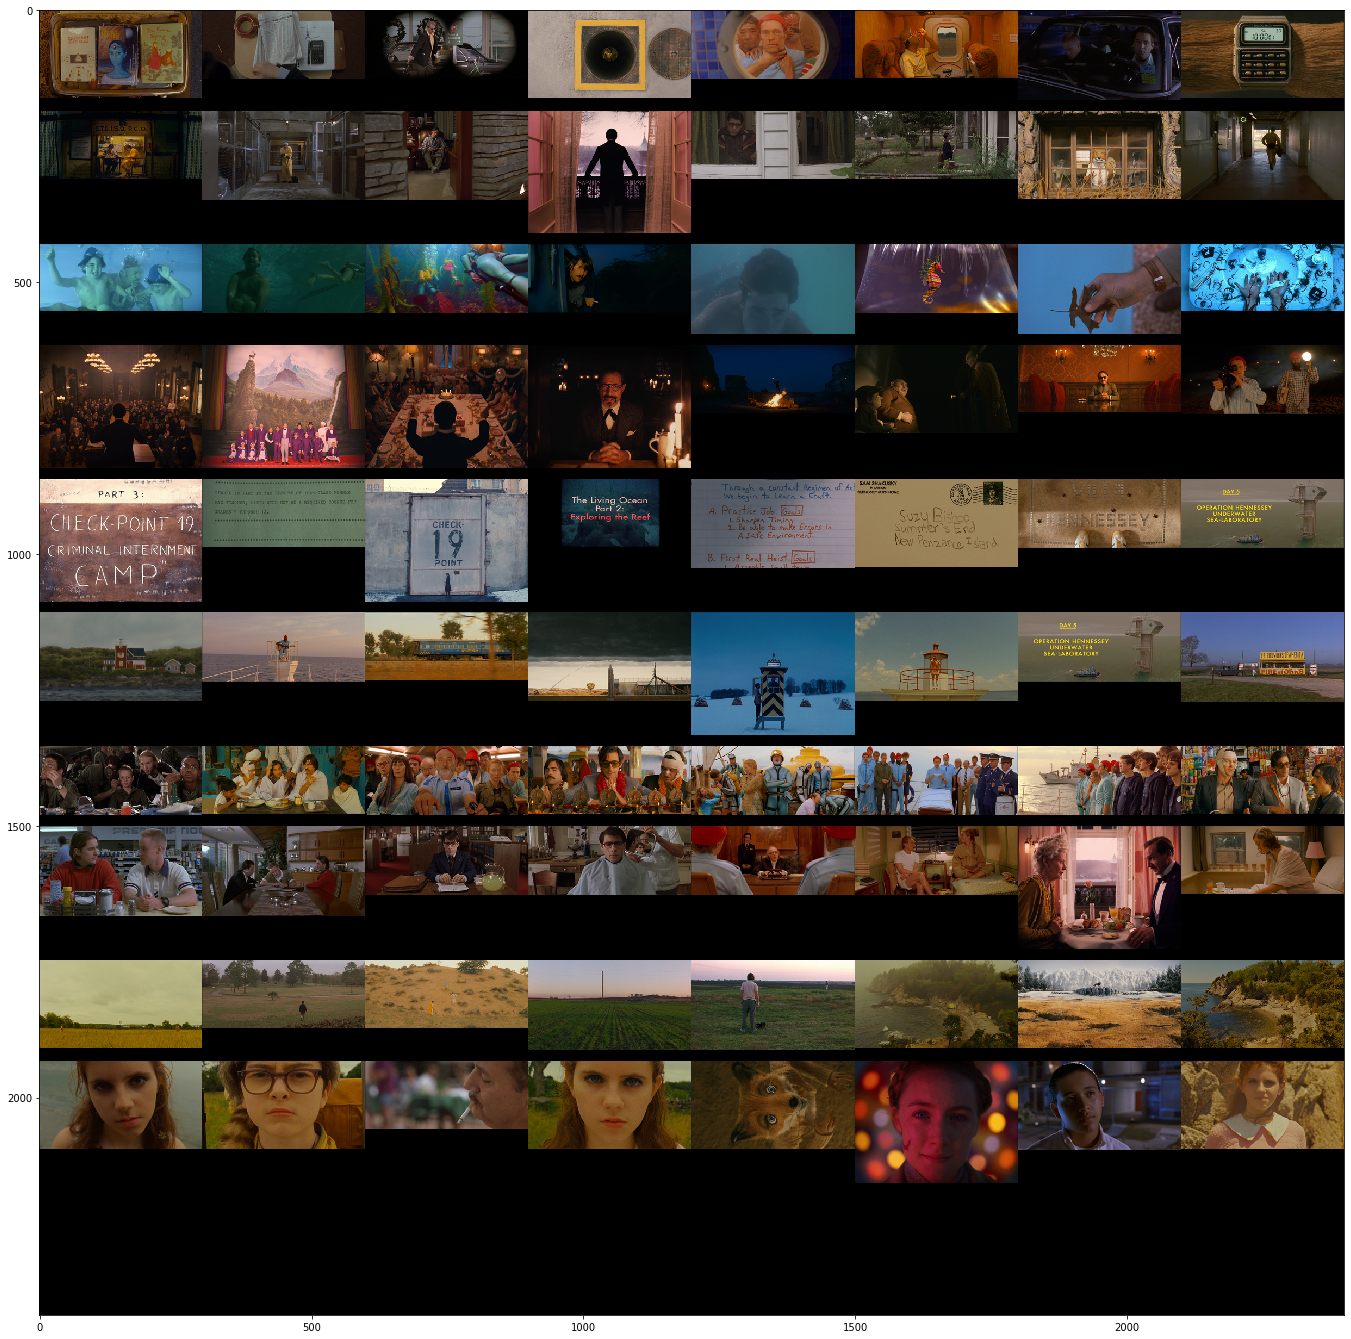

In [20]:
from PIL import Image
img_width = 300

grid_image = Image.new('RGB', (8 * img_width, len(closest) * 240), (0, 0, 0, 255))
max_height = 0
for cluster_row in closest:
    max_height_temp = 0
    xpos = 0
    for col_num in cluster_row:
        img = Image.open(images[col_num])
        img_ar = img.width/img.height
        img = img.resize((img_width,int(img_width/img_ar)), Image.ANTIALIAS)
        max_height_temp = max(max_height_temp,img.height)
        grid_image.paste(img,(xpos,max_height))
        xpos = xpos + img.width
    max_height = max_height + max_height_temp + 20
    
plt.figure(figsize = (32,24))
plt.imshow(grid_image)

In [24]:
import umap
embedding = umap.UMAP().fit_transform(scaled)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(embedding)
embedding_scaled = scaler.transform(embedding)

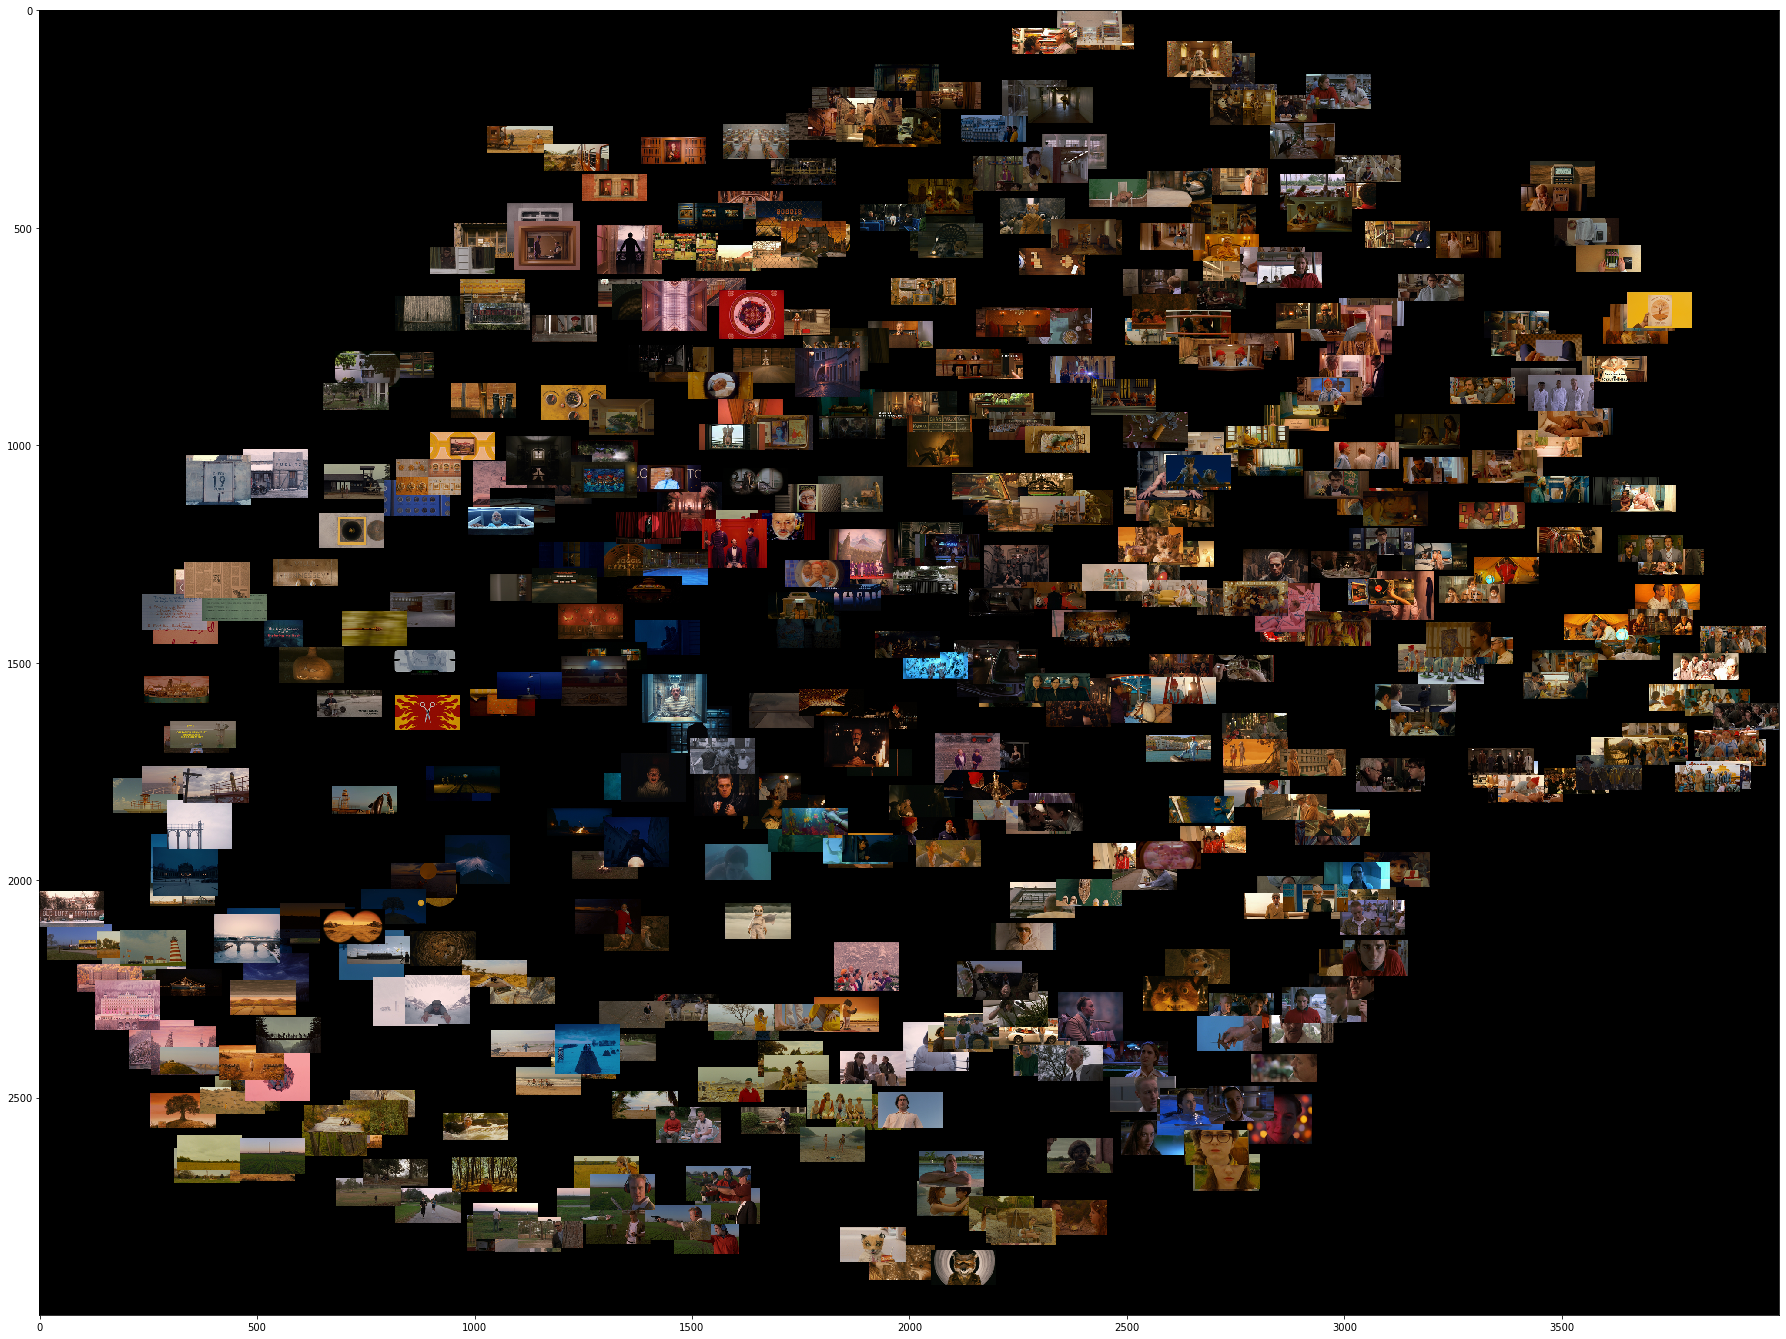

In [31]:
width = 4000
height = 3000
max_dim = 150
full_image = Image.new('RGBA', (width, height), (0, 0, 0, 255))
for img, pos in zip(images, embedding_scaled):
    x = pos[0]
    y = pos[1]
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

plt.figure(figsize = (32,24))
plt.imshow(full_image)
plt.savefig('myimage.svg', format='svg', dpi=1200)

In [41]:
import rasterfairy

nx = 34
ny = 15

grid_assignment = rasterfairy.transformPointCloud2D(embedding, target=(nx, ny))

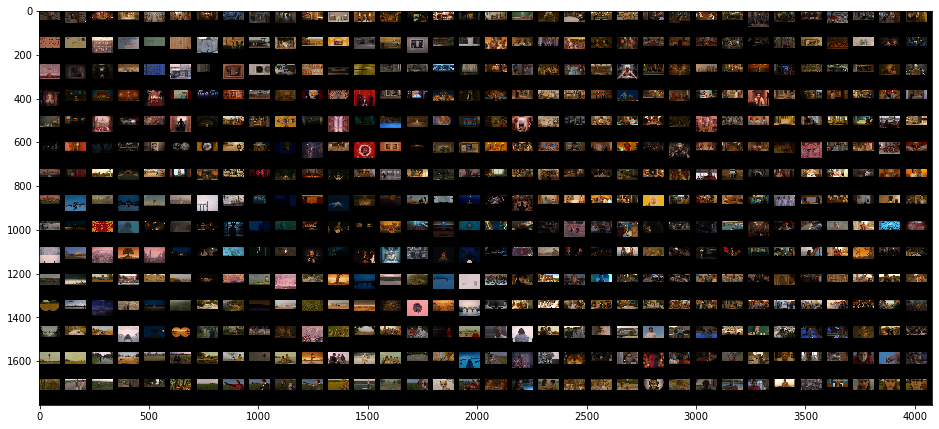

In [42]:
tile_width = 120
tile_height = 120

full_width = tile_width * nx
full_height = tile_height * ny
aspect_ratio = tile_width / tile_height

grid_image = Image.new('RGB', (full_width, full_height), (0, 0, 0, 255))

for img, grid_pos in zip(images, grid_assignment[0]):
    idx_x, idx_y = grid_pos
    x, y = tile_width * idx_x, tile_height * idx_y
    tile = Image.open(img)
    tile_ar = tile.width / tile.height
    tile = tile.resize((int(0.8 * tile_width), int(0.8 * tile_height / tile_ar)), Image.ANTIALIAS)
    grid_image.paste(tile, (int(x), int(y)))

plt.figure(figsize = (16,12))
plt.imshow(grid_image)